Data sourced from: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, power_transform
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, auc,roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

sns.set_theme(style="darkgrid")

### Exploratory Data Analysis

In [3]:
# --- Read in data
 
data = pd.read_csv('data/bank-additional-full.csv',sep=";")

df = data.copy()
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32555,26,blue-collar,married,basic.6y,no,no,no,cellular,may,mon,...,7,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no
2737,38,technician,single,professional.course,unknown,unknown,unknown,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
37555,42,management,married,university.degree,no,yes,no,cellular,aug,fri,...,1,13,1,success,-2.9,92.201,-31.4,0.869,5076.2,yes
12586,44,entrepreneur,married,basic.6y,unknown,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,yes
11552,36,blue-collar,married,basic.9y,no,yes,no,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


d:\Projects\lead_scoring\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\lead_scoring\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\lead_scoring\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Projects\lead_scoring\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Figure size 640x480 with 0 Axes>

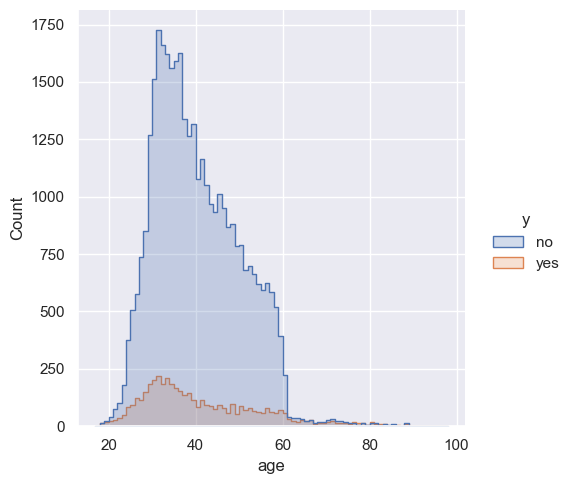

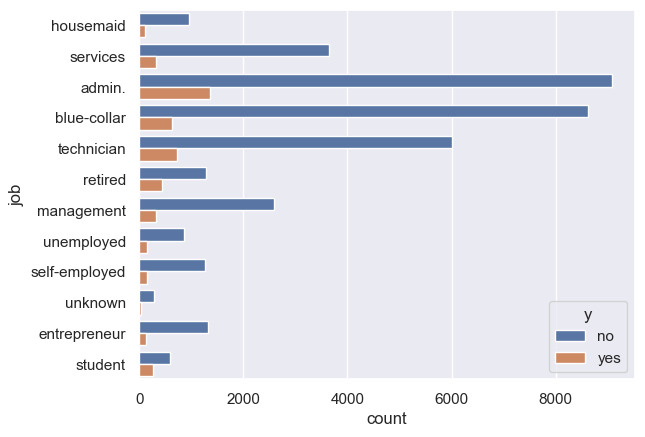

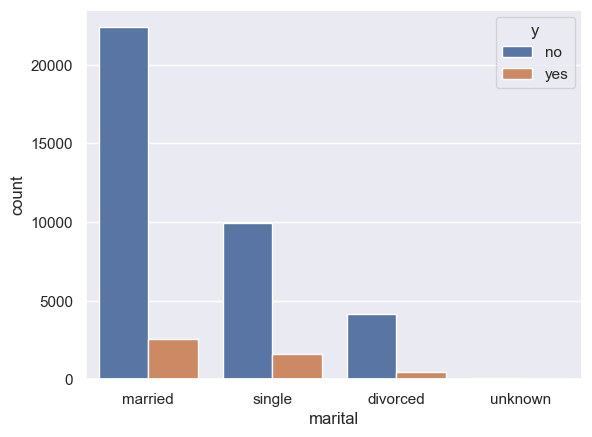

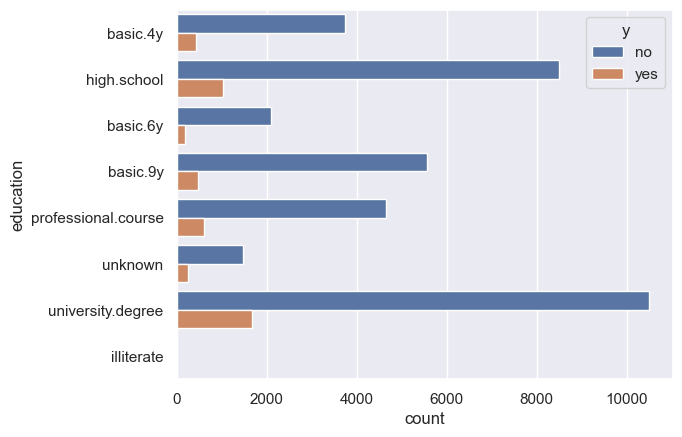

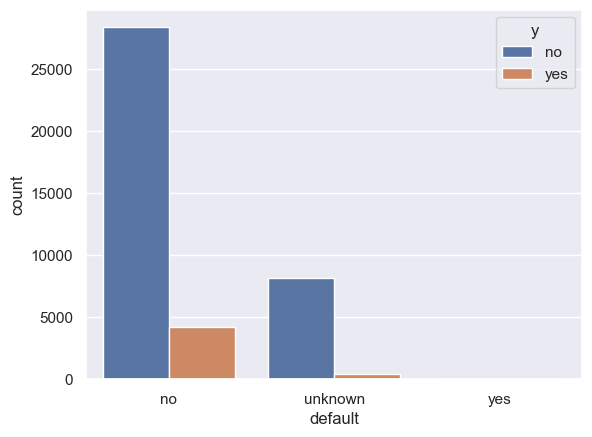

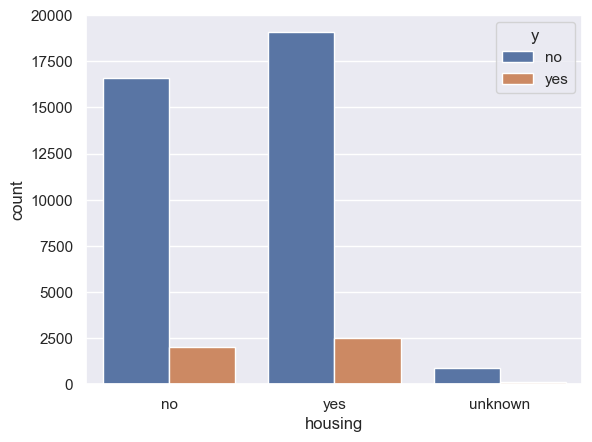

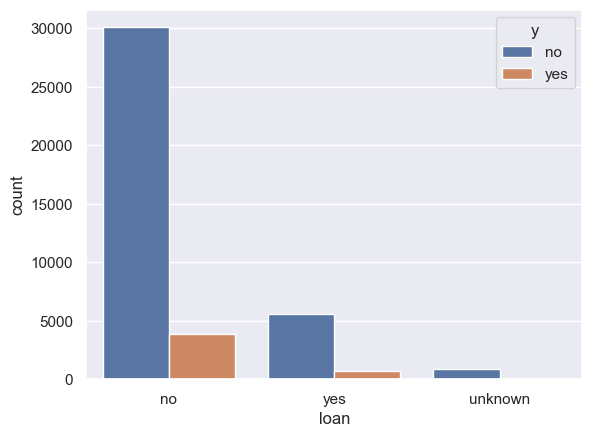

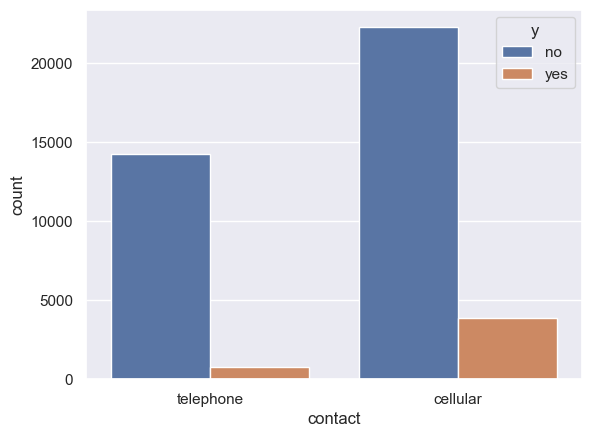

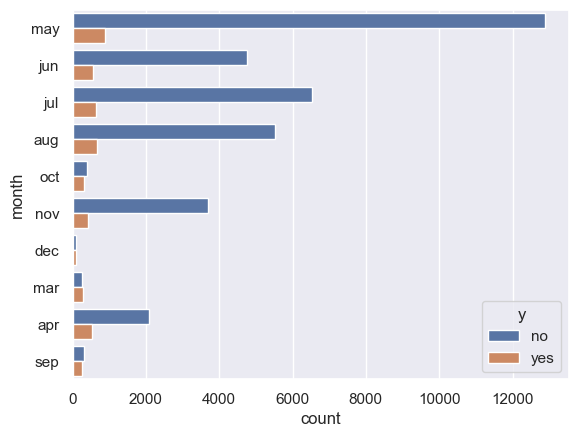

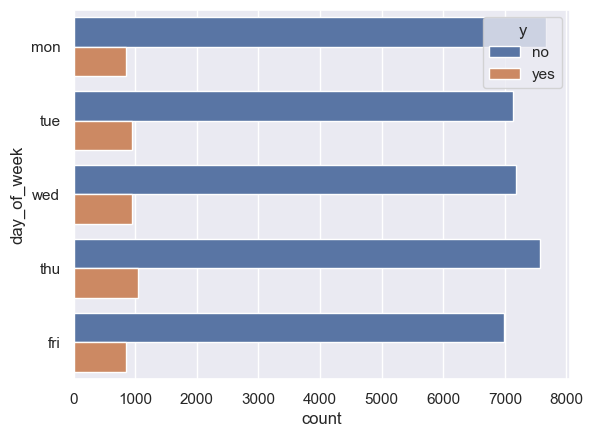

<Figure size 640x480 with 0 Axes>

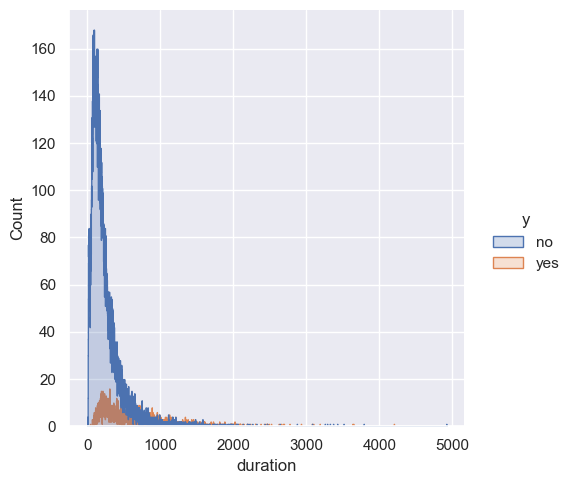

<Figure size 640x480 with 0 Axes>

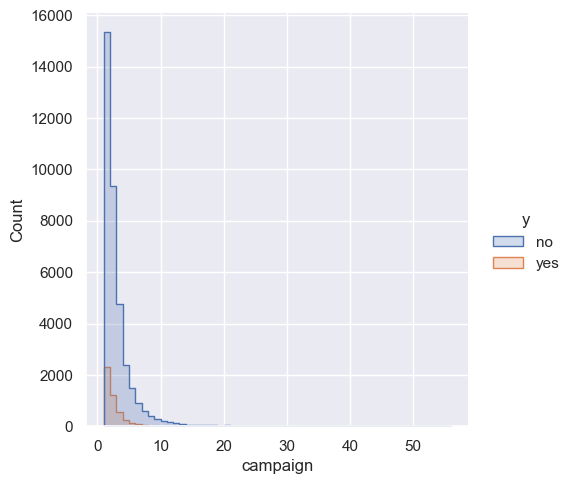

<Figure size 640x480 with 0 Axes>

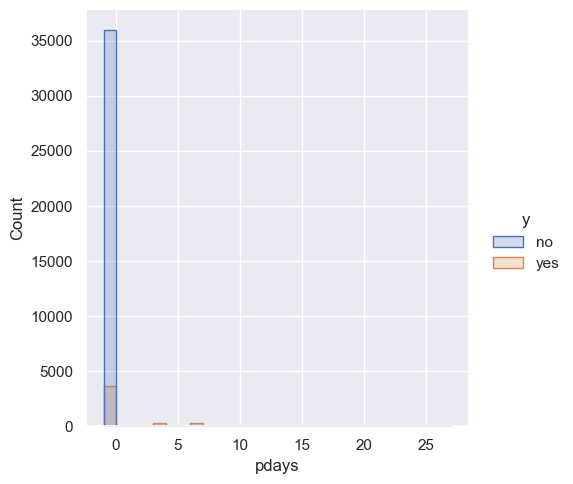

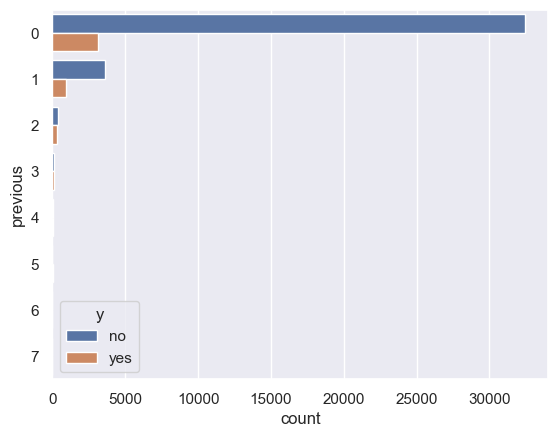

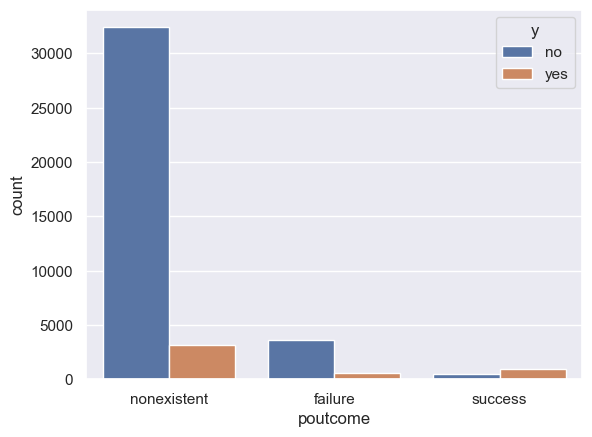

<Figure size 640x480 with 0 Axes>

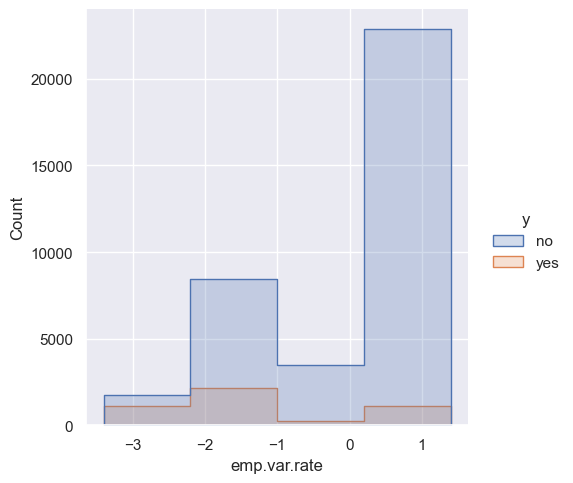

<Figure size 640x480 with 0 Axes>

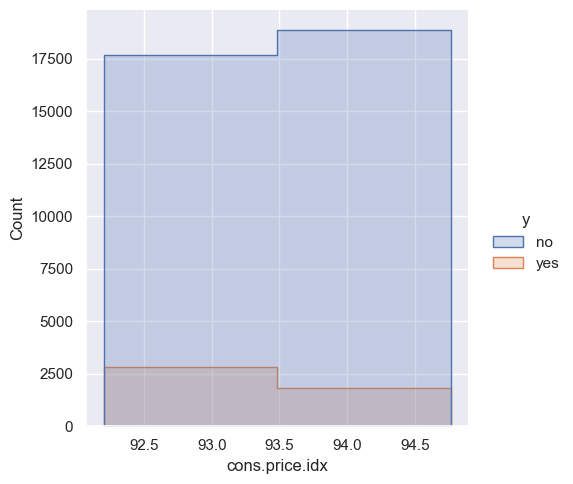

<Figure size 640x480 with 0 Axes>

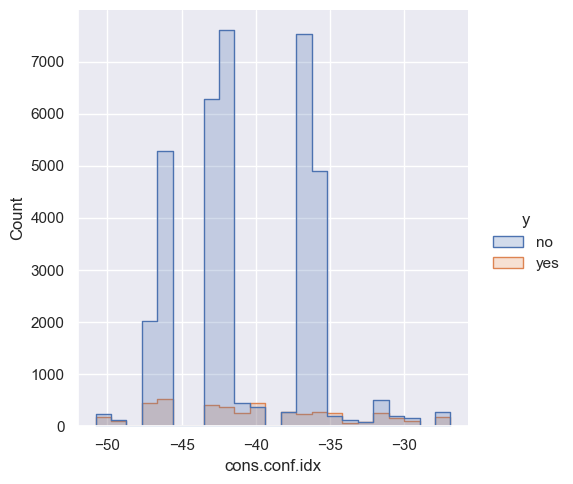

<Figure size 640x480 with 0 Axes>

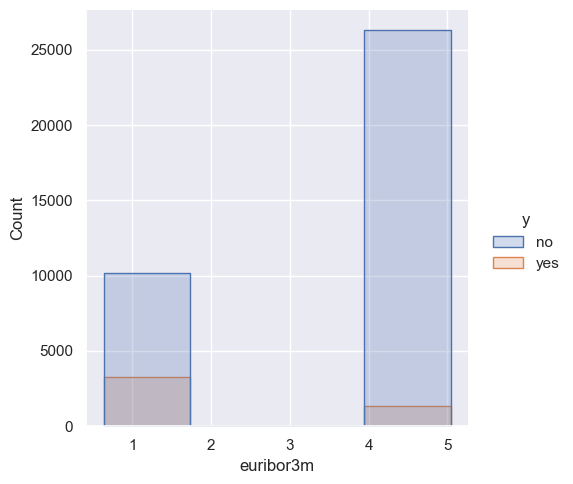

<Figure size 640x480 with 0 Axes>

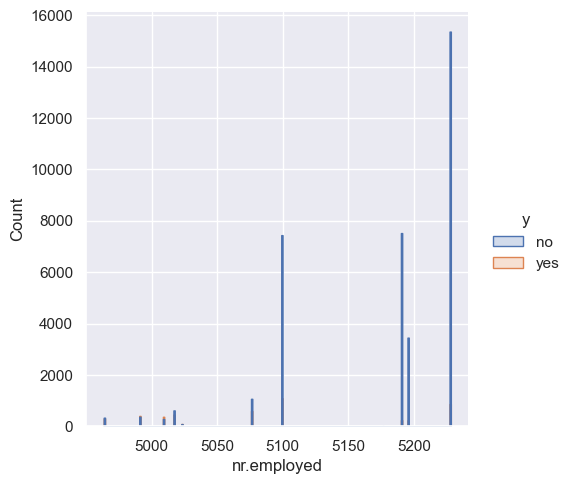

In [9]:
# --- Quick visualizations
index=1
for i in df.drop('y', axis=1).columns:
    plt.figure()
    if is_numeric_dtype(df[i]):
        if len(df[i].unique()) < 10:
            sns.countplot(data=df, y=i, hue="y")    
        else:
            bins = int((max(df[i]) - min(df[i])))
            sns.displot(data=df, x=i, hue="y", bins=bins, element="step")
    elif len(df[i].unique()) > 4:
        sns.countplot(data=df, y=i, hue="y")
    else:    
        sns.countplot(data=df, x=i, hue="y")

In [10]:
df['pdays'] = df['pdays'].replace(999,-1)

In [11]:
df['pdays'].value_counts(normalize=True)

pdays
-1     0.963217
 3     0.010658
 6     0.010003
 4     0.002865
 9     0.001554
 2     0.001481
 7     0.001457
 12    0.001408
 10    0.001263
 5     0.001117
 13    0.000874
 11    0.000680
 1     0.000631
 15    0.000583
 14    0.000486
 8     0.000437
 0     0.000364
 16    0.000267
 17    0.000194
 18    0.000170
 22    0.000073
 19    0.000073
 21    0.000049
 25    0.000024
 26    0.000024
 27    0.000024
 20    0.000024
Name: proportion, dtype: float64

### Feature Engineering & Selection

In [84]:
# --- Convert target colun to 1, 0
y = data['y'] == 'yes'
y = y * 1

# --- Dropping unnecessary columns
X = data.drop(['y', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

# --- Split model into train, test, & validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# --- Check the class distribution in each set
print("------------------------------------------------")
print("Training set class distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print() # <- empty line for spacing

print("------------------------------------------------")
print("Validation set class distribution:")
print(y_val.value_counts())
print(y_val.value_counts(normalize=True))
print() # <- empty line for spacing

print("------------------------------------------------")
print("Testing set class distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

------------------------------------------------
Training set class distribution:
y
0    25583
1     3248
Name: count, dtype: int64
y
0    0.887343
1    0.112657
Name: proportion, dtype: float64

------------------------------------------------
Validation set class distribution:
y
0    5482
1     696
Name: count, dtype: int64
y
0    0.887342
1    0.112658
Name: proportion, dtype: float64

------------------------------------------------
Testing set class distribution:
y
0    5483
1     696
Name: count, dtype: int64
y
0    0.88736
1    0.11264
Name: proportion, dtype: float64


In [85]:
# --- Isolate categorical data
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# --- Apply one-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_cat_encoded = encoder.fit_transform(X_train[categorical_features])
X_train_cat_encoded_names = encoder.get_feature_names_out()
X_train_cat_encoded_names

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'pout

In [86]:
# --- Numerical preprocessing step

# # --- Apply standard scaling for numerical_feature1
# num_stdscale_features = ['age']

# std_scaler = StandardScaler()
# X_train_num_stdscaled = std_scaler.fit_transform(X_train[num_stdscale_features])
# X_train_num_stdscaled_names = [x + '_stdscaled' for x in num_stdscale_features]

# --- Apply min-max scaling for numerical_feature2
num_powertrans_features = ['duration', 'campaign', 'pdays', 'previous']

X_train_num_powertransform = power_transform(X_train[num_powertrans_features])
X_train_num_powertransform_names = [x + '_powertrans' for x in num_powertrans_features]


# --- Bin age groups. 
num_binned_features = ['age']

discretizer = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')

X_train_num_binned =  discretizer.fit_transform(X_train[num_binned_features])
X_train_num_binned_names = ['age_' + x + '_bin' for x in discretizer.get_feature_names_out()]

d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\preprocessing\_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [87]:
X_train_processed = np.hstack((X_train_cat_encoded.toarray(), X_train_num_powertransform, X_train_num_binned.toarray()))

X_train_processed_names = np.hstack((X_train_cat_encoded_names, X_train_num_powertransform_names, X_train_num_binned_names))

X_train_processed_names

array(['job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'pout

In [ ]:
# sns.histplot(X_train_processed[:, np.where(X_train_processed_names == 'poutcome_nonexistent')[0][0]])

In [88]:
X_train_postprocess = pd.DataFrame(data=X_train_processed, columns=X_train_processed_names)
X_train_postprocess = X_train_postprocess.drop(['job_unknown', 'marital_unknown', 'education_unknown', 'default_unknown', 'housing_unknown', 'loan_unknown', 'poutcome_nonexistent'], axis=1)

oversample = SMOTE()
X_train_postprocess, y_train = oversample.fit_resample(X_train_postprocess, y_train)

y_train.value_counts()

y
0    25583
1    25583
Name: count, dtype: int64

In [91]:
# --- Recursive Feature Elimination (RFE)
# model = DecisionTreeClassifier(random_state=42)

model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 20)             
X_train_rfe = rfe.fit_transform(X_train_postprocess, y_train)
rfe_selected_features = X_train_postprocess.columns[rfe.support_]


# print("Feature ranking:")
# print(rfe.ranking_)

# --- Print RFE information
print("\nFeature Selection (RFE):")
print("Selected the top 20 most impactful features.")
print(rfe_selected_features)
X_train_postprocess = X_train_postprocess[rfe_selected_features]


Feature Selection (RFE):
Selected the top 20 most impactful features.
Index(['job_admin.', 'job_blue-collar', 'education_university.degree',
       'default_no', 'housing_no', 'contact_cellular', 'month_apr',
       'month_aug', 'month_jul', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'day_of_week_fri', 'day_of_week_thu',
       'duration_powertrans', 'campaign_powertrans', 'pdays_powertrans',
       'previous_powertrans', 'age_age_1.0_bin'],
      dtype='object')


In [ ]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehote', OneHotEncoder(handle_unknown='ignore'), X_train[categorical_features]),
#         ('stdscale', StandardScaler(), X_train[num_stdscale_features]),
#         ('minmax', MinMaxScaler(), X_train[num_minmaxscale_features]),
#     ])

### Model & Evaluation

In [ ]:
# # --- Logistic Regression parameter optimization
# parameter_set = [    
#     {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-1, 0.01, 1, 10, 100),
#     'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
#     'max_iter' : [100, 500, 1000]
#     }
# ]

# logreg = LogisticRegression()
# logreg_grid = GridSearchCV(logreg, param_grid = parameter_set, cv = 3, verbose=True, n_jobs=-1)
# logreg_model = logreg_grid.fit(X_train_postprocess, y_train)

# print(f"Fitted hyperparameters: {logreg_model.best_estimator_}")

In [95]:
# # --- Fit logreg model using Fitted hyperparameters
logreg = LogisticRegression(C=0.01, max_iter=500, penalty='none')
logreg.fit(X_train_postprocess, y_train)

# # --- Fit Decision Tree model
# dt = DecisionTreeClassifier(random_state=42)
# dt.fit(X_train_postprocess, y_train)

y_pred = logreg.predict(X_train_postprocess)

# --- Calculate scoring metrics
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')

Accuracy: 85.17%
Precision: 84.14%
Recall: 86.67%
F1 Score: 85.39%


d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
d:\Projects\lead_scoring\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:

# --- Get feature importances
feature_importances = logreg.coef_[0]
num_features = X_train_postprocess.shape[1]

# --- Create a list of feature indices
feature_indices = list(range(num_features))

# --- Sort the feature indices by importance in descending order
feature_indices.sort(key=lambda x: feature_importances[x], reverse=True)

# --- Print feature importances, feature names, indices, and ranks
print("Feature Rank, Name, Index, and Coefficient:")
for rank, index in enumerate(feature_indices):
    importance = feature_importances[index]
    name = X_train_postprocess.columns[index]
    print(f"Rank {rank + 1}: {name} | index {index} | Coefficient: {importance:.5f}")

In [93]:
# --- Apply training transformations to validation set

# --- Isolate categorical data
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

X_val_cat_encoded = encoder.transform(X_val[categorical_features])


# # --- Apply standard scaling for numerical_features
# num_stdscale_features = ['age']

# X_val_num_stdscaled = std_scaler.transform(X_val[num_stdscale_features])


# # --- Apply power transform scaling for numerical_features
num_powertrans_features = ['duration', 'campaign', 'pdays', 'previous']

X_val_num_powertransform = power_transform(X_val[num_powertrans_features])


num_binned_features = ['age']

X_val_num_binned = discretizer.transform(X_val[num_binned_features])

# --- Combine processed arrays into validation array
X_val_processed = np.hstack((X_val_cat_encoded.toarray(), X_val_num_powertransform, X_val_num_binned.toarray()))

X_val_postprocess = pd.DataFrame(data=X_val_processed, columns=X_train_processed_names)
X_val_postprocess = X_val_postprocess[rfe_selected_features]
X_val_postprocess

,job_admin.,job_blue-collar,education_university.degree,default_no,housing_no,contact_cellular,month_apr,month_aug,month_jul,month_mar,month_may,month_nov,month_oct,day_of_week_fri,day_of_week_thu,duration_powertrans,campaign_powertrans,pdays_powertrans,previous_powertrans,age_age_1.0_bin
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.514541,0.822927,0.186192,-0.384855,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.447945,1.163646,0.186192,-0.384855,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.589674,0.226080,0.186192,2.597755,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-2.592728,1.643156,0.186192,-0.384855,0.0
4,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.030515,0.226080,0.186192,-0.384855,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6173,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-2.818708,-1.051846,0.186192,-0.384855,1.0
6174,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.702321,1.382030,0.186192,-0.384855,0.0
6175,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.681088,-1.051846,0.186192,-0.384855,1.0
6176,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.133261,0.226080,0.186192,-0.384855,0.0


In [94]:
# --- Predict values for validation set
y_pred = logreg.predict(X_val_postprocess)

# --- Calculate scoring metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')

Accuracy: 85.80%
Precision: 40.46%
Recall: 55.17%
F1 Score: 46.69%


In [96]:
# --- Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred, normalize='true')
print('Confusion Matrix:')
print(conf_matrix)

# --- Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.grid(False)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6178, 51166]

In [ ]:
# --- Calculate AUC-ROC score
y_prob = logreg_model.predict_proba(X_val_postprocess)[:, 1]
roc_auc = roc_auc_score(y_val, y_prob)
print(f'AUC-ROC Score: {roc_auc:.2f}')

# --- Generate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# --- Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [83]:
# --- Preprocess test set

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
X_test_cat_encoded = encoder.transform(X_test[categorical_features])

num_powertrans_features = ['duration', 'campaign', 'pdays', 'previous']
X_test_num_powertransform = power_transform(X_test[num_powertrans_features])

num_binned_features = ['age']
X_test_num_binned = discretizer.transform(X_test[num_binned_features])

# --- Combine processed arrays into test array
X_test_processed = np.hstack((X_test_cat_encoded.toarray(), X_test_num_powertransform, X_test_num_binned.toarray()))
X_test_postprocess = pd.DataFrame(data=X_test_processed, columns=X_train_processed_names)
X_test_postprocess = X_test_postprocess[rfe_selected_features]

# --- Predict values for test set
y_pred_test = logreg.predict(X_test_postprocess)

# --- Calculate scoring metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1 Score: {f1:.2%}')

Accuracy: 84.08%
Precision: 40.14%
Recall: 84.20%
F1 Score: 54.36%
